In [1]:
import os
os.chdir(r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\timeseires')

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [5]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [7]:
def create_lstm():
    input_data = Input(shape=(time_steps, num_features))
    lstm_layer1 = LSTM(8, return_sequences=True)(input_data)
    lstm_layer2 = LSTM(20)(lstm_layer1)
    x = Flatten()(lstm_layer2)
    output_data = Dense(1)(x)
    model = Model(input_data, output_data)
    return model

In [9]:
model1 = create_lstm()
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 21)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 24, 8)               │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20)                  │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301 (12.89 KB)

 Trainable params: 3,301 (12.89 KB)

 Non-trainable params: 0 (0.00 B)

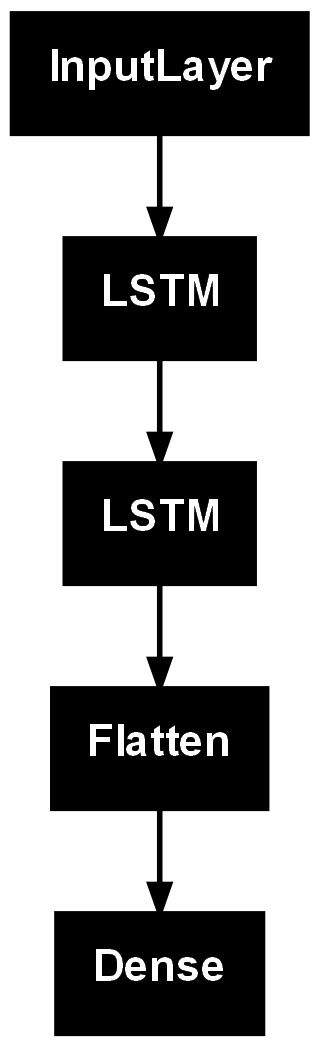

In [11]:
tensorflow.keras.utils.plot_model(model1 )

In [17]:
checkpoints = r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:4: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:4: SyntaxWarning: invalid escape sequence '\h'
C:\Users\USAMA\AppData\Local\Temp\ipykernel_10688\3923681412.py:3: SyntaxWarning: invalid escape sequence '\h'
  FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
C:\Users\USAMA\AppData\Local\Temp\ipykernel_10688\3923681412.py:4: SyntaxWarning: invalid escape sequence '\h'
  JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])


In [19]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [21]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =create_lstm()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [25]:
import os
path_dataset =r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

D:\anconda\envs\MLLab\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((84907, 21), (24259, 21), (12130, 21))

In [27]:
time_steps=24
num_features=21

In [29]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 1.2564058303833008 sec


In [31]:
epochs = 40
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,verbose = verbose)

Epoch 1/40
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0637 - mae: 0.0637 - mape: 382.4761
Epoch 1: val_loss improved from inf to 0.02429, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-0001-loss0.02.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - loss: 0.0637 - mae: 0.0637 - mape: 382.5043 - val_loss: 0.0243 - val_mae: 0.0243 - val_mape: 10.8059
Epoch 2/40
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0202 - mae: 0.0202 - mape: 134.4434
Epoch 2: val_loss improved from 0.02429 to 0.01363, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-0002-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0202 - mae: 0.0202 - mape: 134.4047 - val_loss: 0.0136 - val_mae: 0.0136 - val_mape: 6.4504
Epoch 3/40
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0128 - mae: 0.0128 - mape: 146.6639
Epoch 3: val_loss improved from 0.01363 to 0.01082, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-0003-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0128 - mae: 0.0128 - mape: 146.8496 - val_loss: 0.0108 - val_mae: 0.0108 - val_mape: 5.1746
Epoch 4/40
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - mae: 0.0102 - mape: 144.6614
Epoch 4: val_loss improved from 0.01082 to 0.00935, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-0004-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0102 - mae: 0.0102 - mape: 144.6118 - val_loss: 0.0093 - val_mae: 0.0093 - val_mape: 4.0337
Epoch 5/40
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0093 - mae: 0.0093 - mape: 45.8896
Epoch 5: val_loss improved from 0.00935 to 0.00833, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-0005-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0093 - mae: 0.0093 - mape: 45.9153 - val_loss: 0.0083 - val_mae: 0.0083 - val_mape: 3.5707
Epoch 6/40
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0088 - mae: 0.0088 - mape: 61.9589
Epoch 6: val_loss did not improve from 0.00833
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0088 - mae: 0.0088 - mape: 62.0307 - val_loss: 0.0088 - val_mae: 0.0088 - val_mape: 4.1390
Epoch 7/40
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084 - mae: 0.0084 - mape: 9.4498
Epoch 7: val_loss did not improve from 0.00833
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0084 - mae: 0.0084 - mape: 9.4813 - val_loss: 0.0095 - val_mae: 0.0095 - val_mape: 4.1140
Epoch 8/40
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084 - mae: 0.0084 - mape: 7.7624
Epoch 8: val_loss improved from 0.00833 to 0.00776, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-0008-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0083 - mae: 0.0083 - mape: 7.7664 - val_loss: 0.0078 - val_mae: 0.0078 - val_mape: 3.2254
Epoch 9/40
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0080 - mae: 0.0080 - mape: 55.2317
Epoch 9: val_loss did not improve from 0.00776
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0080 - mae: 0.0080 - mape: 55.3152 - val_loss: 0.0084 - val_mae: 0.0084 - val_mape: 3.7083
Epoch 10/40
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0079 - mae: 0.0079 - mape: 30.6345
Epoch 10: val_loss did not improve from 0.00776
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0079 - mae: 0.0079 - mape: 30.6373 - val_loss: 0.0081 - val_mae: 0.0081 - val_mape: 3.4989
Epoch 11/40
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0077 - mae: 0.0077 - mape: 4.2870
Epoch 11: val_loss improved from 0.00776 to 0.00726, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-0011-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0077 - mae: 0.0077 - mape: 4.3299 - val_loss: 0.0073 - val_mae: 0.0073 - val_mape: 3.1278
Epoch 12/40
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - mae: 0.0076 - mape: 10.4579
Epoch 12: val_loss did not improve from 0.00726
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0076 - mae: 0.0076 - mape: 10.4550 - val_loss: 0.0087 - val_mae: 0.0087 - val_mape: 3.6666
Epoch 13/40
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0075 - mae: 0.0075 - mape: 4.0522
Epoch 13: val_loss did not improve from 0.00726
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0075 - mae: 0.0075 - mape: 4.0598 - val_loss: 0.0080 - val_mae: 0.0080 - val_mape: 3.1631
Epoch 14/40
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0074 - mae: 0.0074 - mape: 7.0083
Epoch 14: val_loss improved from 0.00726 to 0.00710, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-0014-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0074 - mae: 0.0074 - mape: 7.2013 - val_loss: 0.0071 - val_mae: 0.0071 - val_mape: 2.9868
Epoch 15/40
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0073 - mae: 0.0073 - mape: 109.3227
Epoch 15: val_loss did not improve from 0.00710
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0073 - mae: 0.0073 - mape: 109.3072 - val_loss: 0.0071 - val_mae: 0.0071 - val_mape: 3.3212
Epoch 16/40
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0072 - mae: 0.0072 - mape: 6.3933
Epoch 16: val_loss did not improve from 0.00710
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0072 - mae: 0.0072 - mape: 6.3910 - val_loss: 0.0076 - val_mae: 0.0076 - val_mape: 3.9022
Epoch 17/40
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0072 - mae: 0.0072 - mape: 13.1683
Epoch 17: val_loss improved from 0.00710 to 0.00695, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-0017-loss0.01.

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - loss: 0.0072 - mae: 0.0072 - mape: 13.1729 - val_loss: 0.0069 - val_mae: 0.0069 - val_mape: 3.1297
Epoch 18/40
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0071 - mae: 0.0071 - mape: 7.5342
Epoch 18: val_loss improved from 0.00695 to 0.00663, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-0018-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 75s 14ms/step - loss: 0.0071 - mae: 0.0071 - mape: 7.5432 - val_loss: 0.0066 - val_mae: 0.0066 - val_mape: 2.7975
Epoch 19/40
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0071 - mae: 0.0071 - mape: 10.6604
Epoch 19: val_loss did not improve from 0.00663
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0071 - mae: 0.0071 - mape: 10.6771 - val_loss: 0.0074 - val_mae: 0.0074 - val_mape: 3.1745
Epoch 20/40
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0071 - mae: 0.0071 - mape: 9.6967
Epoch 20: val_loss did not improve from 0.00663
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0071 - mae: 0.0071 - mape: 9.7119 - val_loss: 0.0077 - val_mae: 0.0077 - val_mape: 3.3034
Epoch 21/40
2648/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0070 - mae: 0.0070 - mape: 301.7719
Epoch 21: val_loss did not improve from 0.00663
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0070 - mae: 0.0070 - mape: 301.3355 - val_loss: 0.0071 - val_m

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0070 - mae: 0.0070 - mape: 123.3490 - val_loss: 0.0066 - val_mae: 0.0066 - val_mape: 2.8446
Epoch 24/40
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0069 - mae: 0.0069 - mape: 13.9542
Epoch 24: val_loss did not improve from 0.00657
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.0069 - mae: 0.0069 - mape: 13.9598 - val_loss: 0.0068 - val_mae: 0.0068 - val_mape: 2.8680
Epoch 25/40
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0069 - mae: 0.0069 - mape: 67.7699
Epoch 25: val_loss did not improve from 0.00657
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0069 - mae: 0.0069 - mape: 67.7782 - val_loss: 0.0069 - val_mae: 0.0069 - val_mape: 3.0694
Epoch 26/40
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0068 - mae: 0.0068 - mape: 3.1736
Epoch 26: val_loss did not improve from 0.00657
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0068 - mae: 0.0068 - mape: 3.2128 - val_loss: 0.0068 - val_m

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0068 - mae: 0.0068 - mape: 17.3695 - val_loss: 0.0064 - val_mae: 0.0064 - val_mape: 2.6783
Epoch 28/40
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0068 - mae: 0.0068 - mape: 2.2627
Epoch 28: val_loss did not improve from 0.00641
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0068 - mae: 0.0068 - mape: 2.3158 - val_loss: 0.0068 - val_mae: 0.0068 - val_mape: 3.1511
Epoch 29/40
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0068 - mae: 0.0068 - mape: 44.5947
Epoch 29: val_loss did not improve from 0.00641
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0068 - mae: 0.0068 - mape: 44.5797 - val_loss: 0.0070 - val_mae: 0.0070 - val_mape: 2.9545
Epoch 30/40
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067 - mae: 0.0067 - mape: 40.8883
Epoch 30: val_loss did not improve from 0.00641
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0067 - mae: 0.0067 - mape: 40.8765 - val_loss: 0.0067 - val_ma

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0066 - mae: 0.0066 - mape: 5.9945 - val_loss: 0.0062 - val_mae: 0.0062 - val_mape: 2.7479
Epoch 39/40
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0064 - mae: 0.0064 - mape: 3.9700
Epoch 39: val_loss did not improve from 0.00624
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0064 - mae: 0.0064 - mape: 3.9790 - val_loss: 0.0063 - val_mae: 0.0063 - val_mape: 2.6197
Epoch 40/40
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0064 - mae: 0.0064 - mape: 34.7930
Epoch 40: val_loss improved from 0.00624 to 0.00615, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\\E1-cp-0040-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0064 - mae: 0.0064 - mape: 34.8402 - val_loss: 0.0062 - val_mae: 0.0062 - val_mape: 2.7047


In [33]:
model = load_model(r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\E1-cp-0040-loss0.01.h5',
                   custom_objects={'mae': mean_absolute_error})


y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Mean Absolute Error (MAE): 102.63
Median Absolute Error (MedAE): 82.46
Mean Squared Error (MSE): 18218.9
Root Mean Squared Error (RMSE): 134.98
Mean Absolute Percentage Error (MAPE): 0.7 %
Median Absolute Percentage Error (MDAPE): 0.57 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


In [39]:
checkpoints = r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\E1-cp-0040-loss0.01.h5'
start_epoch= 38

In [41]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 10\E1-cp-0040-loss0.01.h5...


TypeError: Could not locate function 'mae'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mae', 'registered_name': 'mae'}

In [20]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2653/2653 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0058 - mape: 14.8268
Epoch 1: val_loss improved from inf to 0.00590, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab10\E2-cp-0001-loss0.01.h5
2653/2653 [==============================] - 58s 21ms/step - loss: 0.0058 - mae: 0.0058 - mape: 14.8268 - val_loss: 0.0059 - val_mae: 0.0059 - val_mape: 2.4532
Epoch 2/10
2653/2653 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0058 - mape: 30.0224
Epoch 2: val_loss did not improve from 0.00590
2653/2653 [==============================] - 60s 23ms/step - loss: 0.0058 - mae: 0.0058 - mape: 30.0224 - val_loss: 0.0060 - val_mae: 0.0060 - val_mape: 2.4553
Epoch 3/10
2652/2653 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0058 - mape: 14.1057
Epoch 3: val_loss did not improve from 0.00590
2653/2653 [==============================] - 58s 22ms/step - loss: 0.0058 - mae: 0.0058 - mape: 14.1030 - va

In [19]:

model = load_model(r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab8\E2-cp-0008-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 103.3
Median Absolute Error (MedAE): 82.18
Mean Squared Error (MSE): 18772.44
Root Mean Squared Error (RMSE): 137.01
Mean Absolute Percentage Error (MAPE): 0.71 %
Median Absolute Percentage Error (MDAPE): 0.57 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)
